### Libraries

In [86]:
import numpy as np
import pandas as pd
from torchvision import datasets, transforms

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.datasets import make_blobs, load_breast_cancer, load_diabetes
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml, load_iris, load_wine, fetch_olivetti_faces, fetch_covtype
from sklearn.manifold import TSNE

from scipy import stats

from global_clustering import GlobalKMeansPP

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import time

### Global variables

In [2]:
random_state = 42

### Silhouette functionality

In [3]:
def macro_silhouette(X, labels):
    sil_samples = silhouette_samples(X, labels)
    cluster_ids = np.unique(labels)
    n_clusters = cluster_ids.shape[0]
    sil_clusters = np.zeros((n_clusters))
    
    for i, c_id in enumerate(cluster_ids):
        indexes = np.where(labels==c_id)[0]
        sil_clusters[i] = np.sum(sil_samples[indexes]) / indexes.shape[0]
        
    macro_sil = np.sum(sil_clusters) / n_clusters
    return sil_clusters, macro_sil

In [4]:
def monte_carlo_macro_silhouette(X, labels, sample_size = 30, n_simulations = 10):
    cluster_ids = np.unique(labels)
    n_clusters = cluster_ids.shape[0]
    silouettes = np.zeros((n_simulations))
    
    for sim_id in range(n_simulations):
        sample_X, sample_labels = list(), list()

        for i, c_id in enumerate(cluster_ids):
            indexes = np.where(labels==c_id)[0]
            sampled_indexes = np.random.choice(indexes, sample_size, replace=False)
            
            sample_X.append(X[sampled_indexes])
            sample_labels.append(labels[sampled_indexes])

        sample_X = np.concatenate(sample_X)
        sample_labels = np.concatenate(sample_labels)

        _, macro_sil = macro_silhouette(sample_X, sample_labels)
        silouettes[sim_id] = macro_sil
        
    avg_silouette = np.sum(silouettes) / n_simulations
    return silouettes, avg_silouette

In [5]:
def monte_carlo_micro_silhouette(X, labels, sample_size = 30, n_simulations = 10):
    silouettes = np.zeros((n_simulations))
    
    for sim_id in range(n_simulations):
        sampled_indexes = np.random.choice(X.shape[0], sample_size, replace=False)
        micro_sil = silhouette_score(X[sampled_indexes], labels[sampled_indexes])
        silouettes[sim_id] = micro_sil
        
    avg_silouette = np.sum(silouettes) / n_simulations
    return silouettes, avg_silouette

### Dataset

In [6]:
def create_imbalance(X, real_labels, imbalance_percentages):
    unique_labels, counts = np.unique(real_labels, return_counts=True)

    new_X, new_labels = [], []

    for label, percentage in zip(unique_labels, imbalance_percentages):
        indices = np.where(real_labels == label)[0]
        num_samples_to_keep = int(len(indices) * percentage)

        selected_indices = np.random.choice(indices, size=num_samples_to_keep, replace=False)

        new_X.extend(X[selected_indices])
        new_labels.extend(real_labels[selected_indices])

    new_X = np.array(new_X)
    new_labels = np.array(new_labels)

    return new_X, new_labels

### Real Dataset

In [7]:
def load_glass():
    df = pd.read_csv('./Data/glass+identification/glass.data', header=None, sep=',')

    labels = df[10].to_numpy()
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]
    
    df.drop(columns=[0, 10], inplace=True)
    X = df.to_numpy()
    X = MinMaxScaler().fit_transform(X)
    
    return X, labels, n_classes, 'Glass'

In [8]:
def load_pendigits():
    data = np.vstack([
        np.loadtxt('./Data/Pendigits/pendigits.tra', delimiter=','),
        np.loadtxt('./Data/Pendigits/pendigits.tes', delimiter=',')
    ])
    
    pendigits, labels = data[:, :-1], data[:, -1:]

    # Fix pendigits
    pendigits = pendigits.astype('float')
    scaler = MinMaxScaler()
    pendigits = scaler.fit_transform(pendigits)

    # Fix labels
    labels = np.squeeze(labels)
    labels = labels.astype('int')
    n_classes = np.unique(labels).shape[0]

    return pendigits, labels, n_classes, 'Pendigits'

In [9]:
def load_mnist_test():
    # Define a transform to normalize the data
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Download MNIST test data
    mnist_test = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

    # Extract test data and labels
    X_test = mnist_test.data.numpy().reshape(len(mnist_test), -1)
    labels_test = np.array(mnist_test.targets)

    # Encode labels
    labels_test = LabelEncoder().fit_transform(labels_test)
    n_classes = np.unique(labels_test).shape[0]

    return X_test, labels_test, n_classes, 'MNIST'

In [10]:
def load_optdigits():
    train = pd.read_csv('./Data/Optdigits/optdigits.tra', header=None)
    test = pd.read_csv('./Data/Optdigits/optdigits.tes', header=None)
    df = pd.concat([train, test], ignore_index=True)
    labels = df[64].to_numpy()
    n_classes = np.unique(labels).shape[0]
    df.drop(columns=[64], inplace=True)
    data = df.to_numpy()
    data = MinMaxScaler().fit_transform(data)
    return data, labels, n_classes, 'Optdigits'

In [11]:
def load_TCGA():
    df_data = pd.read_csv('./Data/TCGA/data.csv', index_col = 0)
    df_labels = pd.read_csv('./Data//TCGA/labels.csv', index_col = 0)

    data = np.array(df_data)
    labels = np.squeeze(np.array(df_labels))

    data = MinMaxScaler().fit_transform(data)
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    return data, labels, n_classes, 'TCGA'

In [12]:
def load_HAR():
    df_data = pd.read_csv('./Data/HAR/X_train.txt', sep='\s+', header=None)
    df_labels = pd.read_csv('./Data/HAR/y_train.txt', sep='\s+', header=None)

    data = np.array(df_data)
    labels = np.squeeze(np.array(df_labels))

    data = MinMaxScaler().fit_transform(data)
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    return data, labels, n_classes, 'HAR'

In [13]:
def load_Isolet():
    df_tr = pd.read_csv('./Data/Isolet/Train/data', header=None)
    df_ts = pd.read_csv('./Data/Isolet/Test/data', header=None)
    df = pd.concat((df_tr, df_ts))

    labels = df[df.columns[-1]].to_numpy()
    df.drop(columns=df.columns[-1], inplace=True)
    data = df.to_numpy()
    
    data = MinMaxScaler().fit_transform(data)
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    return data, labels, n_classes, 'Isolet'

In [14]:
def load_MFCCs():
    df = pd.read_csv('./Data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')
    df.drop(columns=['Family', 'Genus', 'RecordID'], inplace=True)

    labels = df['Species'].to_numpy()
    df.drop(columns=['Species'], inplace=True)
    data = df.to_numpy()

    data = MinMaxScaler().fit_transform(data)
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    return data, labels, n_classes, 'MFCCs'

In [15]:
def load_seeds():
    col_names = ["area", "perimeter", "compactness", "length_of_kernel", "width_of_kernel", "asymmetry_coefficient", "length_of_kernel_groove", "class"]
    df = pd.read_csv("./Data/Seeds/seeds_dataset.txt", sep='\t', names=col_names)
    
    labels = df["class"].to_numpy()
    label_enc = LabelEncoder()
    labels = label_enc.fit_transform(labels)
    n_classes = np.unique(labels).shape[0]
    df.drop(columns=["class"], inplace=True)
    data = df.to_numpy()
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    return data, labels, n_classes, 'Seeds'

In [16]:
def load_pulsars():
    df = pd.read_csv('./Data/HTRU2/HTRU_2.csv', header=None)
    labels = df[8].to_numpy()
    n_classes = np.unique(labels).shape[0]
    df.drop(columns=[8], inplace=True)
    data = df.to_numpy()
    data = MinMaxScaler().fit_transform(data)
    
    return data, labels, n_classes, 'HTRU2'

In [17]:
def load_MAGIC():
    col_names = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
    df = pd.read_csv("./Data/MAGIC/magic04.data", names=col_names)
    labels = df["class"].to_numpy()
    label_enc = LabelEncoder()
    labels = label_enc.fit_transform(labels)
    n_classes = np.unique(labels).shape[0]
    df.drop(columns=["class"], inplace=True)
    data = df.to_numpy()
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    return data, labels, n_classes, 'MAGIC'

In [18]:
def load_Covid(cell_type=False):
    data = np.load("./Data/Covid/scrna_data_matrix.npy")
    
    if cell_type:
        labels = np.load("./Data/Covid/scrna_cell_type_attr.npy", allow_pickle=True)
    else:
        labels = np.load("./Data/Covid/scrna_health_status_attr.npy")
    
    label_enc = LabelEncoder()
    labels = label_enc.fit_transform(labels)
    n_classes = np.unique(labels).shape[0]
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    return data, labels, n_classes, 'Covid'

In [19]:
def load_statlog():
    # Replace 'heart' with the specific Statlog dataset name
    df = pd.read_csv('./Data/statlog+landsat+satellite/sat.trn', header=None, sep='\s+')

    # Assuming the target variable is in the last column (change as needed)
    labels = df.iloc[:, -1].to_numpy()

    # Encoding categorical labels if needed
    labels = LabelEncoder().fit_transform(labels)

    # Dropping the target variable column
    df.drop(columns=[df.columns[-1]], inplace=True)

    # Scaling features
    X = df.to_numpy()
    X = MinMaxScaler().fit_transform(X)

    # Number of classes
    n_classes = np.unique(labels).shape[0]

    return X, labels, n_classes, 'Satellite'


In [20]:
def load_mice_protein():
    df = pd.read_excel('./Data/mice+protein+expression/Data_Cortex_Nuclear.xls', header=0)
    df.drop(columns=['MouseID'], inplace=True)
    df.fillna(value=df.mean(), inplace=True)
    df = pd.get_dummies(df, columns = ['Genotype', 'Treatment', 'Behavior'])

    labels = df['class'].to_numpy()
    df.drop(columns=['class'], inplace=True)

    data = df.to_numpy()
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]
    
    return data, labels, n_classes, 'Mice'

In [21]:
def load_iris_dataset():
    iris_data = load_iris()
    df = pd.DataFrame(data=np.c_[iris_data['data'], iris_data['target']], columns=iris_data['feature_names'] + ['target'])

    labels = df['target'].to_numpy()
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    df.drop(columns=['target'], inplace=True)
    X = df.to_numpy()
    X = MinMaxScaler().fit_transform(X)

    return X, labels, n_classes, 'Iris'

In [22]:
def load_wine_dataset():
    wine_data = load_wine()
    df = pd.DataFrame(data=np.c_[wine_data['data'], wine_data['target']], columns=wine_data['feature_names'] + ['target'])

    labels = df['target'].to_numpy()
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    df.drop(columns=['target'], inplace=True)
    X = df.to_numpy()
    X = MinMaxScaler().fit_transform(X)

    return X, labels, n_classes, 'Wine'

In [23]:
def load_olivetti_faces_dataset():
    olivetti_data = fetch_olivetti_faces(shuffle=True, random_state=random_state)
    faces = olivetti_data.images.reshape((len(olivetti_data.images), -1))

    labels = olivetti_data.target
    n_classes = np.unique(labels).shape[0]

    X = faces.astype(float)
    X = MinMaxScaler().fit_transform(X)

    return X, labels, n_classes, 'Olivetti-Faces'

In [24]:
def load_forest_cover_dataset():
    # Define column names based on the dataset information
    column_names = [
        f'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points'] + [f'Wilderness_Area_{i}' for i in range(4)] + \
        [f'Soil_Type_{i}' for i in range(40)] + ['Cover_Type']

    # Read the dataset into a pandas DataFrame
    df = pd.read_csv('./Data/covertype/covtype.data', header=None, names=column_names)

    # Extract labels and features
    labels = df['Cover_Type'].to_numpy()
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    # Drop the target column and normalize features
    df.drop(columns=['Cover_Type'], inplace=True)
    X = df.to_numpy()
    X = MinMaxScaler().fit_transform(X)

    return X, labels, n_classes, 'Forest Cover Types'

In [25]:
def load_heart_disease_dataset():
    # Load the Cleveland Heart Disease dataset from OpenML
    heart_data = fetch_openml(name="heart", version=1, as_frame=False)

    # Create a DataFrame from the data
    df = pd.DataFrame(data=heart_data.data.toarray(), columns=heart_data.feature_names)

    # Extract labels and features
    labels = heart_data.target.astype(int)
    labels = LabelEncoder().fit_transform(labels)

    n_classes = np.unique(labels).shape[0]

    # Normalize features
    X = MinMaxScaler().fit_transform(df.to_numpy())

    return X, labels, n_classes, 'Heart Disease'

In [26]:
def load_dry_bean_dataset():
    df = pd.read_excel('./Data/DryBeanDataset/Dry_Bean_Dataset.xlsx')

    # Extract labels and features
    labels = df['Class'].to_numpy()
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    # Drop the target column and normalize features
    df.drop(columns=['Class'], inplace=True)
    X = df.to_numpy()
    X = MinMaxScaler().fit_transform(X)

    return X, labels, n_classes, 'Dry Bean'

In [27]:
def load_waveform():
    df_data = pd.read_csv('./Data/waveform+database+generator+version+1/data.csv', header = None)
    df_labels = pd.read_csv('./Data/waveform+database+generator+version+1/labels.csv', header = None)

    data = np.array(df_data)
    labels = df_labels.to_numpy()
    data = MinMaxScaler().fit_transform(data)
    labels = LabelEncoder().fit_transform(labels)
    n_classes = np.unique(labels).shape[0]

    return data, labels, n_classes, 'Waveform v1'

In [78]:
# Passed (WIN)
# X, real_labels, n_classes, dataset_name = load_glass()
# X, real_labels, n_classes, dataset_name = load_pendigits()
# X, real_labels, n_classes, dataset_name = load_olivetti_faces_dataset()

# Maybe (TIE)
X, real_labels, n_classes, dataset_name = load_mice_protein()
# X, real_labels, n_classes, dataset_name = load_wine_dataset()

# To investigate (LOSS)
# X, real_labels, n_classes, dataset_name = load_optdigits()
# X, real_labels, n_classes, dataset_name = load_TCGA()

# Failed
# X, real_labels, n_classes, dataset_name = load_mnist_test()
# X, real_labels, n_classes, dataset_name = load_HAR()
# X, real_labels, n_classes, dataset_name = load_Isolet()
# X, real_labels, n_classes, dataset_name = load_MFCCs()
# X, real_labels, n_classes, dataset_name = load_seeds()
# X, real_labels, n_classes, dataset_name = load_pulsars()
# X, real_labels, n_classes, dataset_name = load_MAGIC()
# X, real_labels, n_classes, dataset_name = load_Covid(cell_type=True)
# X, real_labels, n_classes, dataset_name = load_statlog()
# X, real_labels, n_classes, dataset_name = load_iris_dataset()
# X, real_labels, n_classes, dataset_name = load_forest_cover_dataset()
# X, real_labels, n_classes, dataset_name = load_heart_disease_dataset()
# X, real_labels, n_classes, dataset_name = load_dry_bean_dataset()
# X, real_labels, n_classes, dataset_name = load_waveform()

/tmp/ipykernel_10122/1231010507.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(value=df.mean(), inplace=True)


In [79]:
X.shape, np.unique(real_labels, return_counts=True), n_classes

((1080, 83),
 (array([0, 1, 2, 3, 4, 5, 6, 7]),
  array([150, 135, 150, 135, 135, 105, 135, 135])),
 8)

In [56]:
np.unique(real_labels, return_counts=True)[1].min()/np.unique(real_labels, return_counts=True)[1].max()

0.9222027972027972

### Create impalancing

In [31]:
# imbalance_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# imbalance_percentages = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# imbalance_percentages = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 1.0]

#imbalance_percentages = [1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

#X, real_labels = create_imbalance(X, real_labels, imbalance_percentages)

In [34]:
X.shape, np.unique(real_labels, return_counts=True)

((10000, 784),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])))

### Global $k$-means++ method

In [35]:
n_clusters = 30
global_kmeans_pp = GlobalKMeansPP(n_clusters=n_clusters, n_candidates=10, verbose=True) 
global_kmeans_pp.fit(X)

Solving 2-means
Solving 3-means
Solving 4-means
Solving 5-means
Solving 6-means
Solving 7-means
Solving 8-means
Solving 9-means
Solving 10-means
Solving 11-means
Solving 12-means
Solving 13-means
Solving 14-means
Solving 15-means
Solving 16-means
Solving 17-means
Solving 18-means
Solving 19-means
Solving 20-means
Solving 21-means
Solving 22-means
Solving 23-means
Solving 24-means
Solving 25-means
Solving 26-means
Solving 27-means
Solving 28-means
Solving 29-means
Solving 30-means


GlobalKMeansPP(n_candidates=10, n_clusters=30, verbose=True)

In [36]:
k_list, sil_score_list, macro_sil_score_list = list(), list(), list()
for k in range(2, n_clusters):    
    k_list.append(k)
    original_sil = silhouette_score(X, global_kmeans_pp.labels_[k])
    _, macro_sil = macro_silhouette(X, global_kmeans_pp.labels_[k])
    sil_score_list.append(original_sil)
    macro_sil_score_list.append(macro_sil)
    print(f'k: {k} Micro-averaged Silouette: {original_sil:.3f} Macro-averaged Silhouette: {macro_sil:.3f}')

k: 2 Micro-averaged Silouette: 0.090 Macro-averaged Silhouette: 0.072
k: 3 Micro-averaged Silouette: 0.060 Macro-averaged Silhouette: 0.056
k: 4 Micro-averaged Silouette: 0.063 Macro-averaged Silhouette: 0.060
k: 5 Micro-averaged Silouette: 0.071 Macro-averaged Silhouette: 0.072
k: 6 Micro-averaged Silouette: 0.068 Macro-averaged Silhouette: 0.071
k: 7 Micro-averaged Silouette: 0.073 Macro-averaged Silhouette: 0.071
k: 8 Micro-averaged Silouette: 0.076 Macro-averaged Silhouette: 0.069
k: 9 Micro-averaged Silouette: 0.060 Macro-averaged Silhouette: 0.065
k: 10 Micro-averaged Silouette: 0.059 Macro-averaged Silhouette: 0.063
k: 11 Micro-averaged Silouette: 0.062 Macro-averaged Silhouette: 0.064
k: 12 Micro-averaged Silouette: 0.062 Macro-averaged Silhouette: 0.066
k: 13 Micro-averaged Silouette: 0.064 Macro-averaged Silhouette: 0.066
k: 14 Micro-averaged Silouette: 0.064 Macro-averaged Silhouette: 0.066
k: 15 Micro-averaged Silouette: 0.065 Macro-averaged Silhouette: 0.066
k: 16 Micro-av

In [40]:
silhouette_score(X, real_labels), macro_silhouette(X, real_labels)

(0.04883591250809372,
 (array([ 0.07170199,  0.30149302, -0.02865707,  0.01914136,  0.00668879,
         -0.03455121,  0.0489883 ,  0.04254859, -0.01374491,  0.03281072]),
  0.04464195716054254))

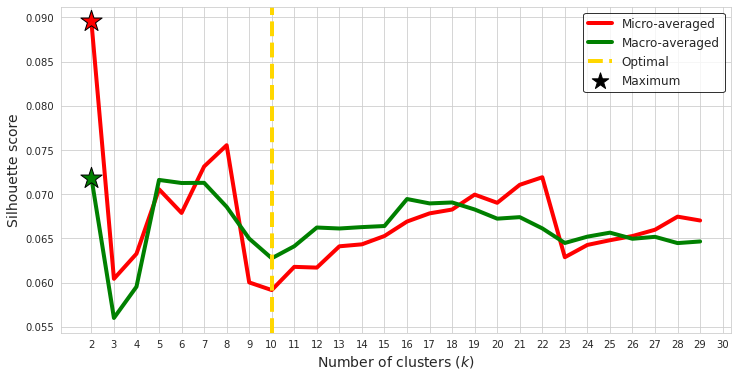

In [38]:
sns.set_style('whitegrid')

lw = 4
fontsize = 14

plt.figure(figsize=(12, 6))
plt.plot(k_list, sil_score_list, label='Micro-averaged', lw=lw, c='red')
plt.plot(k_list, macro_sil_score_list, label='Macro-averaged', lw=lw, c='green')
plt.axvline(x=n_classes, color='gold', linestyle='--', label='Optimal', lw=lw)
plt.scatter(k_list[np.argmax(sil_score_list)], max(sil_score_list), color='black', marker='*', s=300, zorder=0, label='Maximum')
plt.scatter(k_list[np.argmax(sil_score_list)], max(sil_score_list), color='red', marker='*', edgecolors='black', linewidth=1, s=500, zorder=10)
plt.scatter(k_list[np.argmax(macro_sil_score_list)], max(macro_sil_score_list), color='green', marker='*', s=500, edgecolors='black', linewidth=1, zorder=10)

plt.xticks([i for i in range(2, n_clusters + 1)])
# plt.ylim(0.45, 1)
# plt.xlim(2, 21)

plt.xlabel('Number of clusters ($k$)', fontsize=fontsize)
plt.ylabel('Silhouette score', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize-2, frameon=True, edgecolor='black')
# xlt.xlim([50, 10_000])
plt.savefig(f'./Figures/{dataset_name}.png', bbox_inches='tight', facecolor='None')
plt.show()

(array([300.,   0.,   0.,  78.,   0.,   0.,   1.,   0.,   0., 141.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

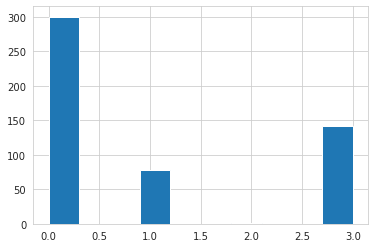

In [65]:
plt.hist(real_labels[np.where(global_kmeans_pp.labels_[3] == 0)])

### Silhouette vs Sample size

In [80]:
n_simulations = 30
n_clusters = np.unique(real_labels).shape[0]
data_size = X.shape[0]
results_macro, results_micro = dict(), dict()

for sample_size in range(2, int(data_size/n_clusters), 1): # range(2, 100): # int(data_size/n_clusters)+1, 1):
    macro_all_sil, _ = monte_carlo_macro_silhouette(X, real_labels, sample_size=sample_size, n_simulations=n_simulations)
    micro_all_sil, _ = monte_carlo_micro_silhouette(X, real_labels, sample_size=sample_size*n_clusters, n_simulations=n_simulations)
    #results_macro[sample_size] = macro_all_sil
    #results_micro[sample_size] = micro_all_sil
    results_macro[100 * sample_size * n_clusters / data_size] = macro_all_sil
    results_micro[100 * sample_size * n_clusters / data_size] = micro_all_sil
    print(f'Sample size: {100 * sample_size * n_clusters / data_size:.2f}%')

Sample size: 1.48%
Sample size: 2.22%
Sample size: 2.96%
Sample size: 3.70%
Sample size: 4.44%
Sample size: 5.19%
Sample size: 5.93%
Sample size: 6.67%
Sample size: 7.41%
Sample size: 8.15%
Sample size: 8.89%
Sample size: 9.63%
Sample size: 10.37%
Sample size: 11.11%
Sample size: 11.85%
Sample size: 12.59%
Sample size: 13.33%
Sample size: 14.07%
Sample size: 14.81%
Sample size: 15.56%
Sample size: 16.30%
Sample size: 17.04%
Sample size: 17.78%
Sample size: 18.52%
Sample size: 19.26%
Sample size: 20.00%
Sample size: 20.74%
Sample size: 21.48%
Sample size: 22.22%
Sample size: 22.96%
Sample size: 23.70%
Sample size: 24.44%
Sample size: 25.19%
Sample size: 25.93%
Sample size: 26.67%
Sample size: 27.41%
Sample size: 28.15%
Sample size: 28.89%
Sample size: 29.63%
Sample size: 30.37%
Sample size: 31.11%
Sample size: 31.85%
Sample size: 32.59%
Sample size: 33.33%
Sample size: 34.07%
Sample size: 34.81%
Sample size: 35.56%
Sample size: 36.30%
Sample size: 37.04%
Sample size: 37.78%
Sample size:

KeyboardInterrupt: 

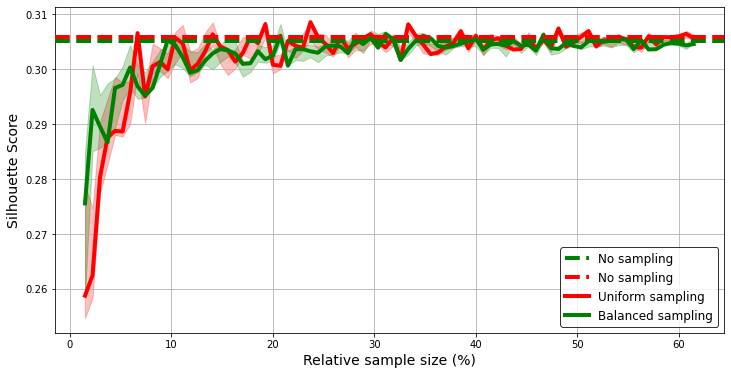

In [88]:
fontsize = 14
lw = 4
alpha = 0.25

plt.figure(figsize=(12, 6))


plt.axhline(y=macro_silhouette(X, real_labels)[1], color='green', linestyle='--', label='No sampling', lw=4, zorder=10)
plt.axhline(y=silhouette_score(X, real_labels), color='red', linestyle='--', label='No sampling', lw=4, zorder=10)

plt.plot(results_micro.keys(), [np.median(results_micro[key]) for key in results_micro.keys()], 
         linewidth=lw, label='Uniform sampling', c='red')

plt.plot(results_macro.keys(), [np.median(results_macro[key]) for key in results_macro.keys()], 
         linewidth=lw, label='Balanced sampling', c='green')

plt.fill_between(results_micro.keys(), 
                 [np.quantile(results_micro[key], .25) - 1.5 * (np.quantile(results_micro[key], .75) - np.quantile(results_micro[key], .25)) for key in results_micro.keys()],
                 [np.quantile(results_micro[key], .75) + 1.5 * (np.quantile(results_micro[key], .75) - np.quantile(results_micro[key], .25)) for key in results_micro.keys()],
                 alpha=alpha, color='red')

plt.fill_between(results_macro.keys(), 
                 [np.quantile(results_macro[key], .25) - 1.5 * (np.quantile(results_macro[key], .75) - np.quantile(results_macro[key], .25)) for key in results_macro.keys()],
                 [np.quantile(results_macro[key], .75) + 1.5 *(np.quantile(results_macro[key], .75) - np.quantile(results_macro[key], .25))  for key in results_macro.keys()], 
                 alpha=alpha, color='green')
'''
plt.fill_between(results_micro.keys(), 
                 [np.mean(results_micro[key]) - stats.sem(results_micro[key]) for key in results_micro.keys()],
                 [np.mean(results_micro[key]) + stats.sem(results_micro[key]) for key in results_micro.keys()],
                 alpha=alpha, color='red')

plt.fill_between(results_micro.keys(), 
                 [np.mean(results_macro[key]) - stats.sem(results_macro[key]) for key in results_macro.keys()],
                 [np.mean(results_macro[key]) + stats.sem(results_macro[key]) for key in results_macro.keys()],
                 alpha=alpha, color='green')
'''

# plt.xticks([i for i in results_macro.keys() if (math.ceil(i * 100) / 100) % 0.1 == 0])
# plt.xlim(0, 20)
# plt.ylim(0.1, 0.3)

plt.xlabel('Relative sample size (%)', fontsize=fontsize)
plt.ylabel('Silhouette Score', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize-2, frameon=True, edgecolor='black')
plt.grid()
# plt.show()
plt.savefig(f'Sil_vs_sample_size_{dataset_name}.png', bbox_inches='tight', facecolor=None)

In [82]:
results_micro

{1.4814814814814814: array([0.21989481, 0.30268894, 0.31319424, 0.27972842, 0.29730525,
        0.22879123, 0.3253359 , 0.17914137, 0.37185913, 0.24361081,
        0.16305101, 0.23210671, 0.35996163, 0.20256885, 0.17008259,
        0.15292567, 0.25138623, 0.26614059, 0.21760051, 0.28677067,
        0.35775619, 0.30319426, 0.40578162, 0.2355635 , 0.24668097,
        0.28770283, 0.35652701, 0.23723104, 0.20014027, 0.30874946]),
 2.2222222222222223: array([0.30476991, 0.44132578, 0.27186393, 0.26228461, 0.19492195,
        0.23126273, 0.21933658, 0.25638249, 0.29764466, 0.22522429,
        0.27197926, 0.31750511, 0.26700568, 0.29090421, 0.2483765 ,
        0.26260419, 0.27897953, 0.29003522, 0.20430304, 0.25268089,
        0.26507568, 0.25414349, 0.26093265, 0.21569216, 0.3162909 ,
        0.25565011, 0.24649639, 0.24395474, 0.27333099, 0.27412847]),
 2.962962962962963: array([0.32282104, 0.32330293, 0.2561029 , 0.32565066, 0.28387368,
        0.28714961, 0.24625703, 0.21424916, 0.3390126

### $t$-SNE reduction

/home/giorgos/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


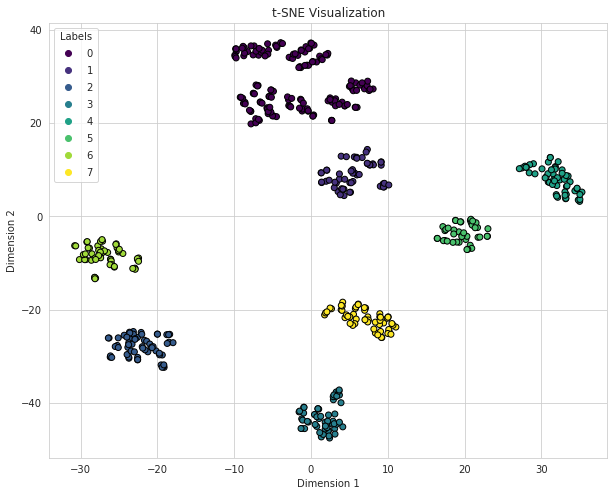

In [128]:
# Perform t-SNE
tsne = TSNE(n_components=2, init='random', random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for visualization
df_tsne = pd.DataFrame(data={'Dimension 1': X_tsne[:, 0], 'Dimension 2': X_tsne[:, 1], 'Labels': real_labels})

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne['Dimension 1'], df_tsne['Dimension 2'], c=df_tsne['Labels'], cmap='viridis', edgecolor='black')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(*scatter.legend_elements(), title='Labels')
plt.show()


0.012076348933534915